# Random Forests
Random forests are used to find a labelled target variable, and can be used with numeric and categorical target variables. They combine predicitons from other models, taking decision trees from smaller models to build a larger model.

Random forests work by creating multiple decision trees with different, random data subsets, and using that to work out the best result.



In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [2]:
characteristics = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/ChildCharacteristics.csv')
identifiers = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/ChildIdentifiers.csv')
cpps = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/CINdetails.csv')
print(characteristics.info())
print(identifiers.info())
print(cpps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  332 non-null    int64 
 1   LAchildID   332 non-null    object
 2   Ethnicity   332 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               332 non-null    int64  
 1   LAchildID                332 non-null    object 
 2   UPN                      332 non-null    object 
 3   FormerUPN                0 non-null      float64
 4   UPNunknown               0 non-null      float64
 5   PersonBirthDate          332 non-null    object 
 6   ExpectedPersonBirthDate  0 non-null      float64
 7   GenderCurrent            332 non-null    int64

In [3]:
cpps.drop_duplicates('LAchildID', inplace=True)
cpps = cpps[['LAchildID']]
cpps['CP Plan'] = 1

identifiers = identifiers[['LAchildID', 'PersonBirthDate', 'GenderCurrent']]

df = characteristics.merge(identifiers, how='left', on='LAchildID').merge(cpps, how='left', on='LAchildID')

df['CP Plan'] = df['CP Plan'].fillna(0)




In [4]:

def ethnicity_check(row):
    if row[0] == 'W':
        return 'white'
    if (row[0] == 'A' ) | (row[0] == 'C' ):
        return 'asian'
    if row[0] == 'M':
        return 'mixed'
    if row[0] == 'B':
        return 'black'
    else:
        return 'unknown'
    
df['Ethnicity'] = df['Ethnicity'].apply(ethnicity_check)
df['GenderCurrent'] = df['GenderCurrent'].map({1:'male',
                                               2:'female',
                                               0:'other'})

In [5]:
df['PersonBirthDate'] = pd.to_datetime(df['PersonBirthDate'])
df['Age'] = pd.to_datetime('1/11/23', dayfirst=True) - df['PersonBirthDate']
df.drop(['Unnamed: 0', 'PersonBirthDate'], inplace=True, axis=1)
df['Age'] = df['Age']/pd.Timedelta(days=365)
df

,LAchildID,Ethnicity,GenderCurrent,CP Plan,Age
0,RND000215205141,white,male,1.0,3.906849
1,RND000824303014,white,NaN,1.0,12.523288
2,RND000750143123,asian,male,1.0,6.408219
3,RND000909164501,mixed,other,1.0,9.084932
4,RND000382171815,asian,female,1.0,4.104110
...,...,...,...,...,...
327,RND000112711501,white,female,0.0,13.328767
328,RND000513120794,white,female,0.0,5.219178
329,RND000541643134,black,male,0.0,1.895890
330,RND000404939452,asian,female,0.0,10.282192


In [6]:
df_encoded = pd.get_dummies(df[['GenderCurrent', 'Ethnicity']])
cp = df[['CP Plan', 'Age']]
full_encoded_df = cp.merge(df_encoded, how='left', left_index=True, right_index=True)
full_encoded_df

,CP Plan,Age,GenderCurrent_female,GenderCurrent_male,GenderCurrent_other,Ethnicity_asian,Ethnicity_black,Ethnicity_mixed,Ethnicity_unknown,Ethnicity_white
0,1.0,3.906849,False,True,False,False,False,False,False,True
1,1.0,12.523288,False,False,False,False,False,False,False,True
2,1.0,6.408219,False,True,False,True,False,False,False,False
3,1.0,9.084932,False,False,True,False,False,True,False,False
4,1.0,4.104110,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
327,0.0,13.328767,True,False,False,False,False,False,False,True
328,0.0,5.219178,True,False,False,False,False,False,False,True
329,0.0,1.895890,False,True,False,False,True,False,False,False
330,0.0,10.282192,True,False,False,True,False,False,False,False


# Workflow
As with previous weeks, our workflow after cleaning will be: choose features, split data, train model, tune hyperparameters, assess performance

In [7]:
# Split data to train/test split
X = full_encoded_df.drop('CP Plan', axis=1) # Independent
y = full_encoded_df['CP Plan'] # Dependent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5970149253731343


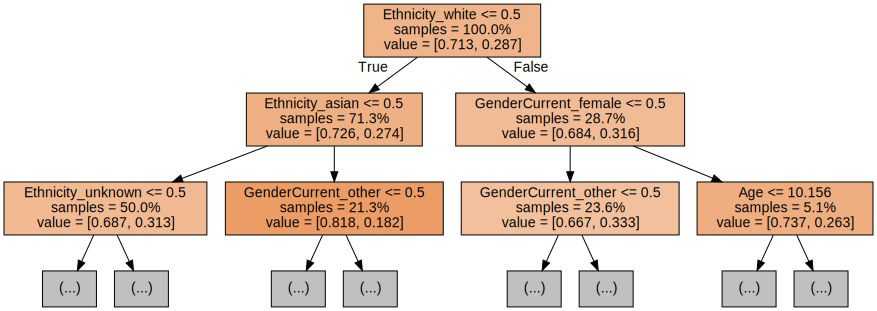

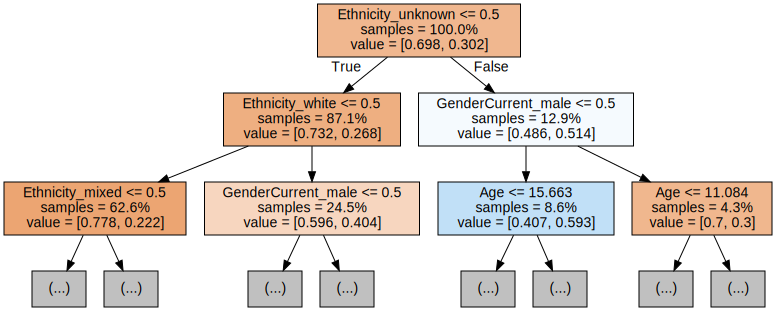

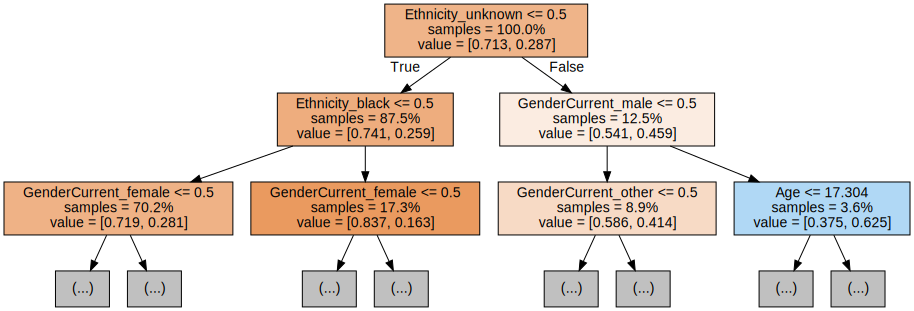

In [9]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

The trees all show the first few nodes to keep them simple. The darker the colour the more of one outcome in each node. The nodes have information about which variable is sued for the splitting, the percent of total samples in the split, and the percent split between classes in the split.

We can now move to tuning our hyperparameters. If we use SKlearn's RandomisedSearchCV, it performs a randomized search on hyper parameters within a set range of parameters.

Estimators are the number of trees in the forest, more trees improves accuracy, but increases computational cost.
Max depth is how deep each tree in the forest goes with node splits, too many will overfit, too few will underfit.

RandomizedSearchCV makes lots of models and returns a variable for the best one, which includes information about the hyperparameters.

In [10]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4883720400>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f48b933b4f0>})

In [11]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 498}


Let's look at the confusion matrix, which shows us predicitons against actual values for our model

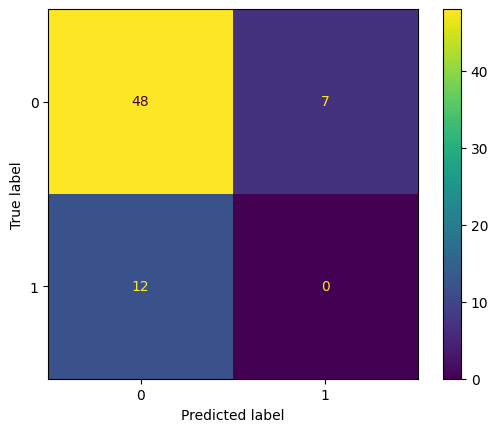

In [12]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

We can use KNN to look at how important factors we have used in our decision tree are to outcomes.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6417910447761194
Precision: 0.125
Recall: 0.16666666666666666


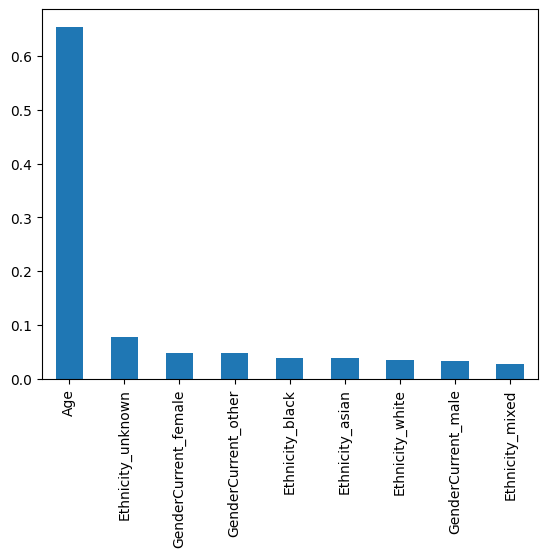

In [14]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();